In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob

/var/folders/0w/fv69fs7s6959xkvtvbw8_7h80000gn/T/ipykernel_7169/1116083728.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Import Data

In [2]:
#Import Dataset
labeled_index = pd.read_csv("../data/labeled_data/quarterly_labeled_features_standardized.csv")
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())
print(labeled_index)

#Features Columns
features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
print(features_columns)

            volatility      index  crash_label  price_change  volume_change  \
date                                                                          
1998-03-31   -0.628541  000001.SS            0      0.187709      -0.127147   
1998-06-30   -0.628541  000001.SS            0      0.504913      -0.127147   
1998-09-30   -0.625680  000001.SS            1     -0.795446      -0.127147   
1998-12-31   -0.631403  000001.SS            0     -0.843210      -0.127147   
1999-03-31   -0.629515  000001.SS            0     -0.082838      -0.127147   
...                ...        ...          ...           ...            ...   
2018-12-31   -0.493234      ^SSMI            0     -0.800378      -0.127147   
2019-03-31   -0.529809      ^SSMI            0      0.914383      -0.127147   
2019-06-30   -0.458321      ^SSMI            0      0.217264      -0.127147   
2019-09-30   -0.388212      ^SSMI            0     -0.010617      -0.127147   
2019-12-31   -0.351813      ^SSMI            0      

# Build the model

In [3]:
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []

for train_index, test_index in tscv.split(quarters):
    
    train_quarters, test_quarters = quarters[train_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Undersample the majority class (0) using RandomUnderSampler
    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_oversampled, y_train_oversampled)

    # Hyperparameter Tuning
    param_grid = {'max_depth':[3,5,7], 'n_estimators':[50,100,200], 'learning_rate':[0.1,0.01,0.001]}
    grid_search = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=5, verbose=2)
    try:
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    except Exception as e:
        print("Error occurred during grid search:")
        print(e)

    # Train the model
    model = xgb.XGBClassifier(max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate']
    )
    model.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to a file
    # joblib.dump(model, 'logistic_regression_model.joblib')
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict decision values on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix,
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Calculate feature importance
    feature_names = list(X_train.columns)
    feature_importance = model.feature_importances_
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_e

In [4]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_XGBoost_features.csv", index=False)
evaluation_df
#TODO: visualize it

,Train_Start,Train_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,Accuracy,RMSE,...,10YGov_BondYield_importance,current_acct_importance,FX_Rate_importance,turnover_importance,Population_importance,npl_importance,Recession_Indicators_importance,inflation_importance,Unemployment_importance,GDP_importance
0,1998-03-31,2002-06-30,2002-09-30,2005-12-31,"[[100, 27], [8, 5]]",0.156250,0.384615,0.222222,0.750000,0.500000,...,0.189691,0.027991,0.026695,0.049514,0.073739,0.131230,0.014766,0.0,0.032031,0.093480
1,1998-03-31,2005-12-31,2006-03-31,2009-06-30,"[[96, 14], [12, 18]]",0.562500,0.600000,0.580645,0.814286,0.430946,...,0.055178,0.019150,0.035156,0.074715,0.052806,0.026092,0.043613,0.0,0.026754,0.049516
2,1998-03-31,2009-06-30,2009-09-30,2012-12-31,"[[112, 20], [0, 8]]",0.285714,1.000000,0.444444,0.857143,0.377964,...,0.036999,0.022635,0.040707,0.040543,0.050066,0.057290,0.082042,0.0,0.020577,0.040046
3,1998-03-31,2012-12-31,2013-03-31,2016-06-30,"[[120, 9], [5, 6]]",0.400000,0.545455,0.461538,0.900000,0.316228,...,0.029221,0.034177,0.032203,0.054789,0.049873,0.031320,0.075180,0.0,0.030360,0.034341
4,1998-03-31,2016-06-30,2016-09-30,2019-12-31,"[[125, 14], [0, 1]]",0.066667,1.000000,0.125000,0.900000,0.316228,...,0.032407,0.027781,0.033952,0.056337,0.046083,0.048865,0.072088,0.0,0.031651,0.054244


# Feature Importance

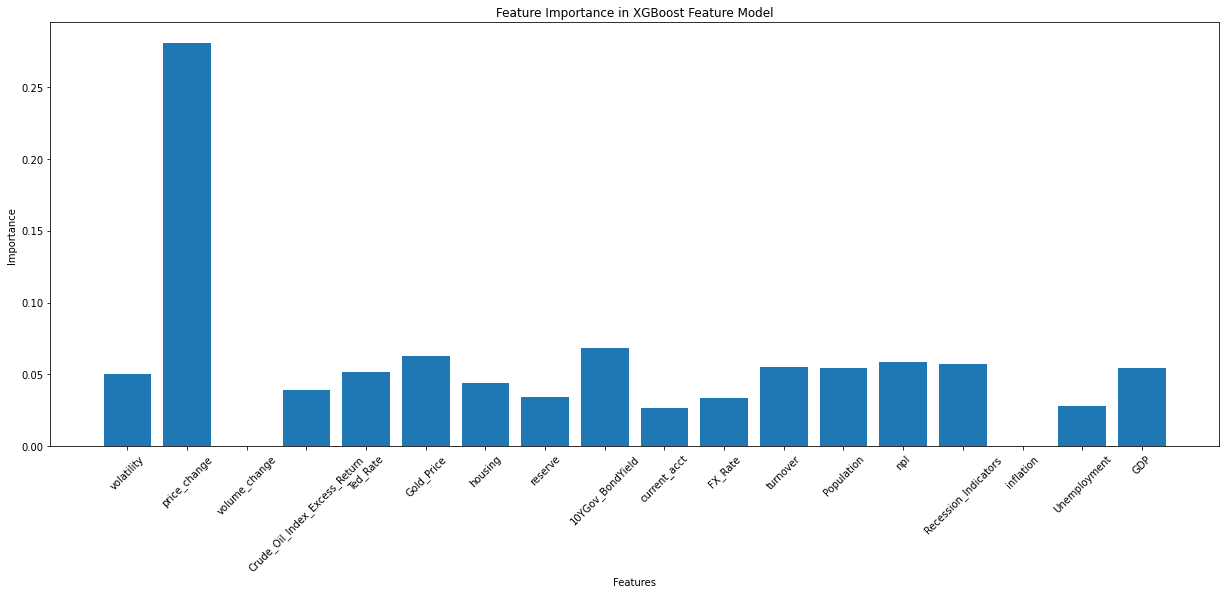

In [5]:
model_name = "XGBoost Feature"
plot_feature_importances(evaluation_df, model_name)

# AUC-ROC

In [6]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.8777109822191254


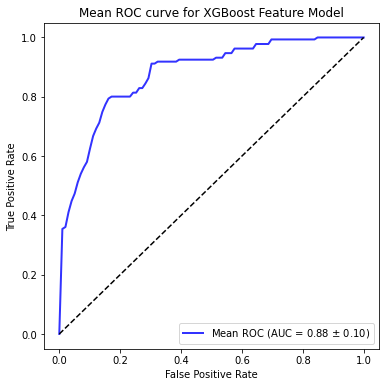

In [7]:
plot_roc_curve(evaluation_df, model_name)